In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import linear_model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/AI-Cyber-Detector/data/raw/UNSW_NB15_training-set.csv')
test_data = pd.read_csv('/content/drive/MyDrive/AI-Cyber-Detector/data/raw/UNSW_NB15_testing-set.csv')

In [ ]:

print(test_data.shape)
train_data.head()

(175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
print(test_data.shape)
test_data.head()

(175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

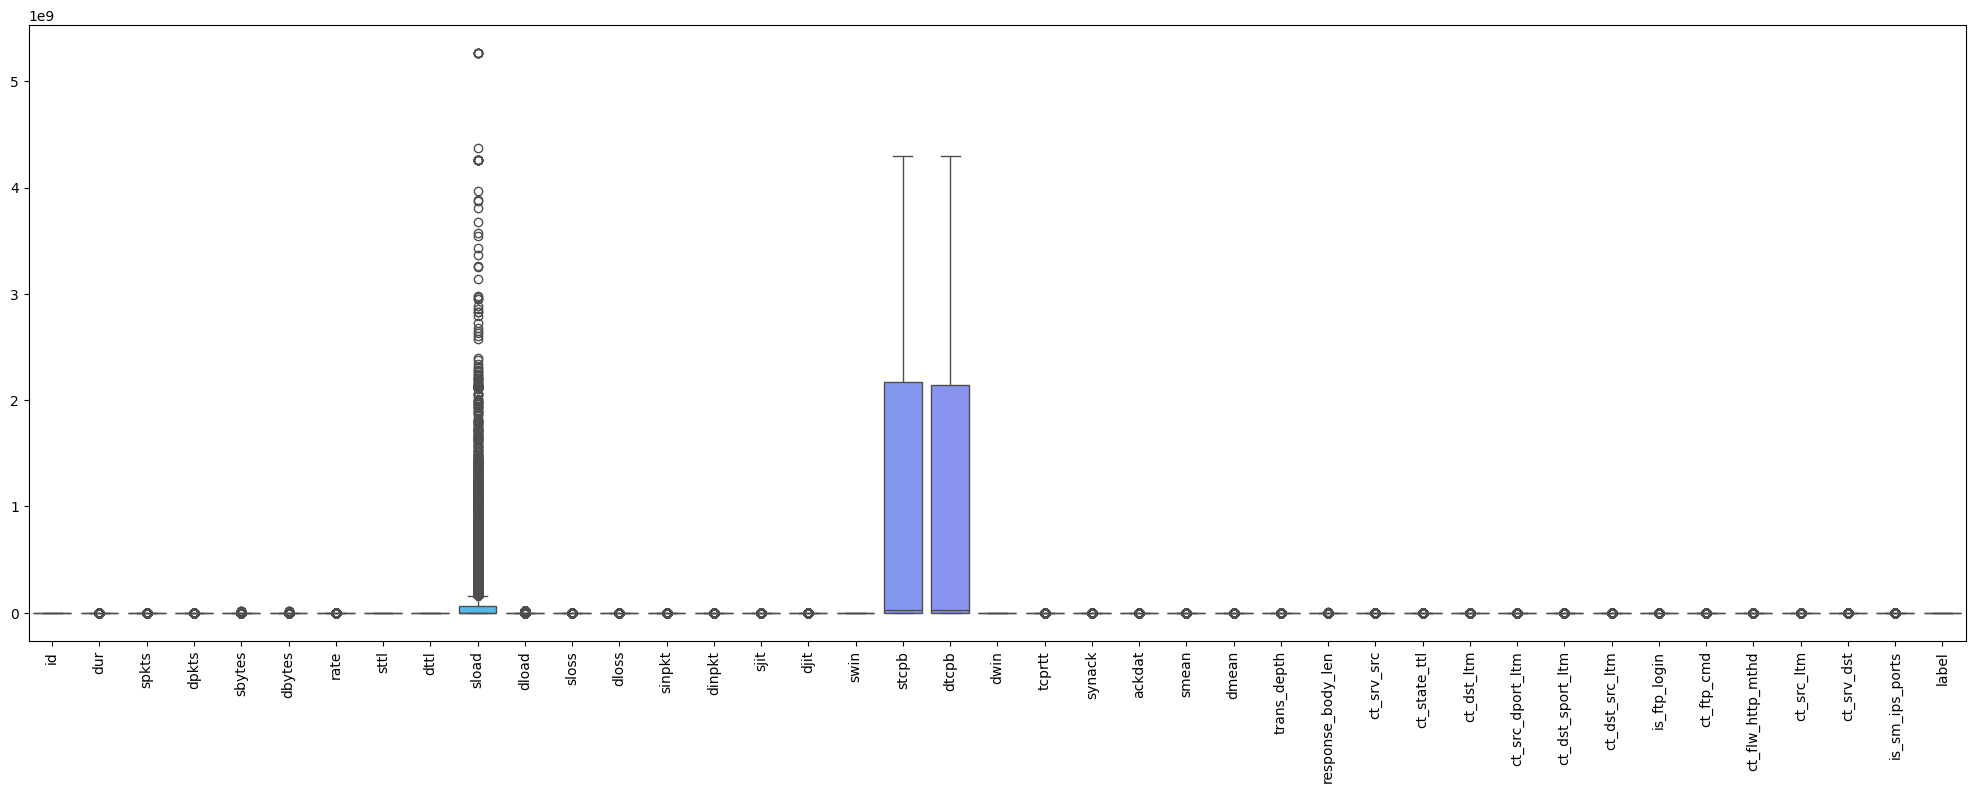

In [ ]:
plt.figure(figsize = (25,8))
u = sns.boxplot(palette = 'cool', data=train_data)
u.set_xticklabels(u.get_xticklabels(),rotation=90);

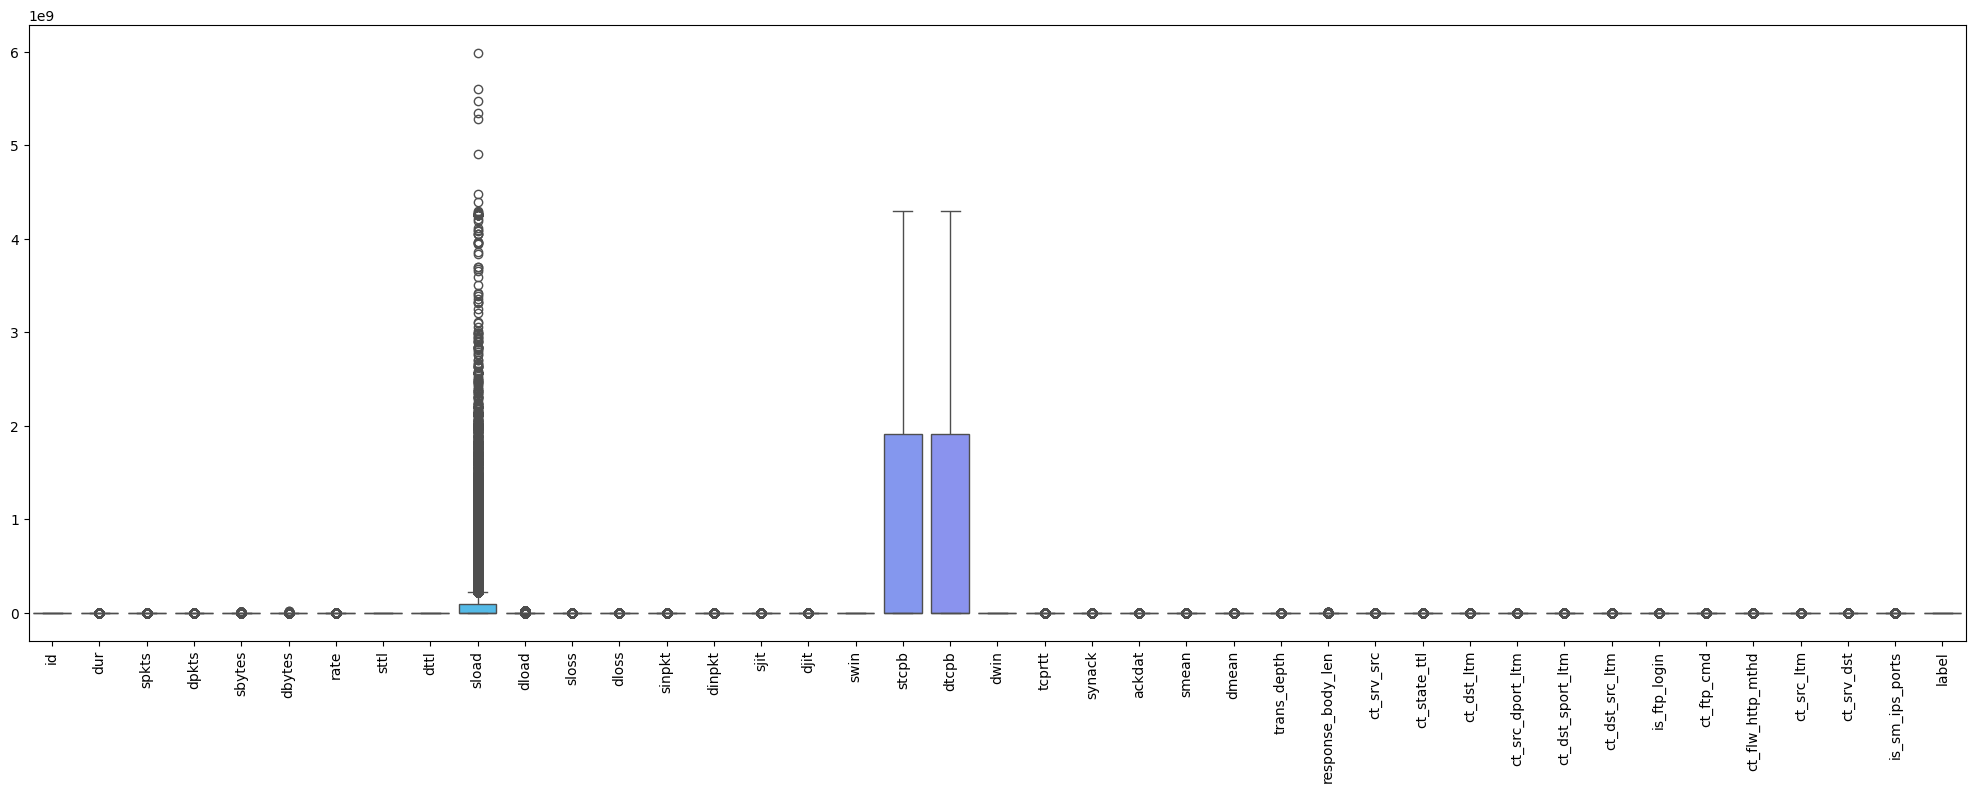

In [ ]:
plt.figure(figsize = (25,8))
u = sns.boxplot(palette = 'cool', data=test_data)
u.set_xticklabels(u.get_xticklabels(),rotation=90);

In [ ]:
fig = px.box(train_data, y='sload')
fig.show()

In [ ]:
fig = px.box(test_data, y='sload')
fig.show()

In [ ]:
new_train_data = train_data.copy()
new_train_data = train_data.drop(train_data[train_data['sload']>162400000].index)

new_test_data = test_data.copy()
new_test_data = test_data.drop(test_data[test_data['sload']>222000000].index)


In [ ]:
print(new_test_data.shape)
print(new_train_data.shape)

(161823, 45)
(75617, 45)


In [ ]:
# 1) Drop attack_cat properly
new_train_data = new_train_data.drop(columns=['attack_cat'])
new_test_data  = new_test_data.drop(columns=['attack_cat'])

# 2) Keep label separately
y_train = new_train_data['label'].astype(int)
X_train = new_train_data.drop(columns=['label'])

y_test = new_test_data['label'].astype(int)
X_test = new_test_data.drop(columns=['label'])

# 3) Identify categorical + numeric columns
cat_cols = ['proto', 'service', 'state']
num_cols = [c for c in X_train.columns if c not in cat_cols]

# 4) Preprocess: OneHot for categoricals, scale numeric
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", MinMaxScaler(), num_cols),
    ],
    remainder="drop"
)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, n_jobs=None))
])

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, proba))


              precision    recall  f1-score   support

           0     0.3732    0.9028    0.5281     54459
           1     0.8241    0.2309    0.3608    107364

    accuracy                         0.4570    161823
   macro avg     0.5987    0.5669    0.4444    161823
weighted avg     0.6724    0.4570    0.4171    161823

ROC-AUC: 0.7291649434136895


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)
pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, proba))


              precision    recall  f1-score   support

           0     0.6108    0.9588    0.7462     54459
           1     0.9706    0.6901    0.8067    107364

    accuracy                         0.7805    161823
   macro avg     0.7907    0.8245    0.7764    161823
weighted avg     0.8495    0.7805    0.7863    161823

ROC-AUC: 0.9129446765136824


In [ ]:
rf_new = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=500,
        min_samples_leaf=2,
        class_weight="balanced",   # ✅ improves recall balance
        n_jobs=-1,
        random_state=42
    ))
])

rf_new.fit(X_train, y_train)

rf_new_pred_default  = rf_new.predict(X_test)
rf_new_proba         = rf_new.predict_proba(X_test)[:, 1]

print("\n====================")
print("RANDOM FOREST (0.5 threshold)")
print("====================")
print(classification_report(y_test, rf_new_pred_default, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, rf_new_proba))


RANDOM FOREST (0.5 threshold)
              precision    recall  f1-score   support

           0     0.6021    0.9553    0.7387     54459
           1     0.9677    0.6798    0.7986    107364

    accuracy                         0.7725    161823
   macro avg     0.7849    0.8176    0.7687    161823
weighted avg     0.8447    0.7725    0.7785    161823

ROC-AUC: 0.9145187591409542


In [ ]:
print("\n====================")
print("RF THRESHOLD TUNING")
print("====================")
for t in [0.20, 0.30, 0.40, 0.50, 0.60]:
    pred_t = (rf_new_proba >= t).astype(int)
    print(f"\n--- Threshold = {t:.2f} ---")
    print(classification_report(y_test, pred_t, digits=4))


RF THRESHOLD TUNING

--- Threshold = 0.20 ---
              precision    recall  f1-score   support

           0     0.7829    0.7334    0.7574     54459
           1     0.8690    0.8969    0.8827    107364

    accuracy                         0.8419    161823
   macro avg     0.8260    0.8151    0.8200    161823
weighted avg     0.8400    0.8419    0.8405    161823


--- Threshold = 0.30 ---
              precision    recall  f1-score   support

           0     0.7632    0.9100    0.8302     54459
           1     0.9494    0.8568    0.9007    107364

    accuracy                         0.8747    161823
   macro avg     0.8563    0.8834    0.8655    161823
weighted avg     0.8868    0.8747    0.8770    161823


--- Threshold = 0.40 ---
              precision    recall  f1-score   support

           0     0.6775    0.9310    0.7842     54459
           1     0.9568    0.7752    0.8565    107364

    accuracy                         0.8276    161823
   macro avg     0.8171    0.

In [ ]:
import joblib
joblib.dump(clf, "/content/drive/MyDrive/AI-Cyber-Detector/data/lr_threat_detector.joblib")
joblib.dump(rf_new, "/content/drive/MyDrive/AI-Cyber-Detector/data/rf_threat_detector.joblib")

print("\n✅ Saved:")
print(" - lr_threat_detector.joblib")
print(" - rf_threat_detector.joblib")


✅ Saved:
 - lr_threat_detector.joblib
 - rf_threat_detector.joblib


In [ ]:
!pip -q install fastapi uvicorn nest-asyncio pyngrok joblib pandas


In [ ]:
import nest_asyncio
import uvicorn
import joblib
import pandas as pd
import numpy as np

from pydantic import BaseModel
from pyngrok import ngrok
from fastapi import FastAPI, WebSocket, WebSocketDisconnect
from fastapi.middleware.cors import CORSMiddleware
from typing import List, Dict, Any
import json


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/AI-Cyber-Detector/data/rf_threat_detector.joblib"
THRESHOLD = 0.30

In [ ]:

import sys, time, asyncio, traceback, logging
from collections import deque
from typing import List, Optional

import joblib
import pandas as pd
import nest_asyncio
import uvicorn

from fastapi import FastAPI, Request
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel



In [ ]:
from fastapi import FastAPI, WebSocket, WebSocketDisconnect
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from typing import List, Dict, Any, Optional
from collections import deque
from datetime import datetime
import os
import time
import json
import traceback

import joblib
import pandas as pd

In [ ]:
# ============================================================
# MODEL_PATH = os.getenv("MODEL_PATH", "rf_threat_detector.joblib")
THRESHOLD = float(os.getenv("THRESHOLD", "0.30"))

# local default port
PORT = int(os.getenv("PORT", "8000"))
HOST = os.getenv("HOST", "0.0.0.0")

# Optional ngrok
USE_NGROK = os.getenv("USE_NGROK", "false").lower() in ("1", "true", "yes", "y")
NGROK_AUTHTOKEN = os.getenv("392vSfugNWnv7hVTLyvRPkItjL1_6VGdCqWzZngEjkTqP1NPY", "")

# In-memory alert store (last N)
ALERTS = deque(maxlen=500)

In [ ]:
# ----------------------------
# LOGGING
# ----------------------------
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s | %(levelname)s | %(message)s",
    stream=sys.stdout,
)
logger = logging.getLogger("ThreatDetector")

In [ ]:
def risk_level(score: float) -> str:
    return "HIGH" if score >= 0.7 else "MEDIUM" if score >= 0.4 else "LOW"

In [ ]:
logger.info("Loading model...")
model = joblib.load(MODEL_PATH)
logger.info(f"✅ Model loaded from: {MODEL_PATH}")

In [ ]:
app = FastAPI(
    title="AI Cyber Threat Detector",
    description="Random Forest based IDS",
    version="1.0"
)

EXPECTED_COLS: Optional[List[str]] = None
try:
    prep = model.named_steps.get("prep", None)
    if prep is not None and hasattr(prep, "feature_names_in_"):
        EXPECTED_COLS = list(prep.feature_names_in_)
        logger.info(f"✅ Detected expected raw columns: {len(EXPECTED_COLS)}")
    else:
        logger.warning("⚠️ Could not detect expected columns (prep.feature_names_in_ missing).")
except Exception:
    logger.error("⚠️ Column detection failed", exc_info=True)



# ----------------------------
# REQUEST LOGGER
# ----------------------------
# Live request logging
@app.middleware("http")
async def log_requests(request: Request, call_next):
    logger.info(f"➡️  {request.method} {request.url.path}")
    response = await call_next(request)
    logger.info(f"⬅️  {request.method} {request.url.path} → {response.status_code}")
    return response
# ----------------------------
# IN-MEMORY ALERT STORE
# ----------------------------
ALERTS = deque(maxlen=500)  # store last 500 alerts


# ----------------------------
# SCHEMAS
# ----------------------------
from pydantic import BaseModel, ConfigDict

class TrafficEvent(BaseModel):
    record: dict


class BatchRequest(BaseModel):

    records: List[Dict[str, Any]]

class PredictionRequest(BaseModel):
  model_config = ConfigDict(extra="allow")
# matches your old local style: request.features
  features: Dict[str, Any]




app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class ConnectionManager:
    def __init__(self):
        self.active_connections: List[WebSocket] = []

    async def connect(self, websocket: WebSocket):
        await websocket.accept()
        self.active_connections.append(websocket)

    def disconnect(self, websocket: WebSocket):
        if websocket in self.active_connections:
            self.active_connections.remove(websocket)

    async def broadcast(self, message: dict):
        """Broadcast JSON message to all active clients"""
        dead = []
        payload = json.dumps(message)

        for ws in self.active_connections:
            try:
                await ws.send_text(payload)
            except Exception:
                dead.append(ws)

        for ws in dead:
            self.disconnect(ws)


manager = ConnectionManager()

def align_record_to_expected_cols(record: Dict[str, Any]) -> pd.DataFrame:
    df = pd.DataFrame([record])
    if EXPECTED_COLS is not None:
        df = df.reindex(columns=EXPECTED_COLS, fill_value=0)
    return df

def make_response(pred_int: int, score: float, latency_ms: float) -> dict:
    lvl = risk_level(score)
    threat_detected = bool(pred_int == 1 and score >= 0.4)

    return {
        "prediction": int(pred_int),                 # 0/1
        "threat_score": float(score),                # 0..1
        "risk_level": lvl,                           # LOW/MEDIUM/HIGH
        "threat_detected": threat_detected,          # bool
        "threshold": THRESHOLD,
        "latency": round(float(latency_ms), 2),      # ms
        "timestamp": datetime.utcnow().isoformat() + "Z",
    }

@app.get("/health")
def health():
    logger.info("Health check.......")
    return {"status": "running"}

@app.get("/template")
def template():
    t = {c: 0 for c in EXPECTED_COLS} if EXPECTED_COLS else {}

    # small sensible defaults
    if "id" in t: t["id"] = 1
    if "dur" in t: t["dur"] = 0.2
    if "proto" in t: t["proto"] = "tcp"
    if "service" in t: t["service"] = "http"
    if "state" in t: t["state"] = "FIN"
    if "spkts" in t: t["spkts"] = 4
    if "dpkts" in t: t["dpkts"] = 2
    if "sbytes" in t: t["sbytes"] = 200
    if "dbytes" in t: t["dbytes"] = 100

    return {"record": t}



@app.get("/expected_columns")
def expected_columns():
    logger.info("Expected columns requested")
    if EXPECTED_COLS is None:
        return {"available": False}
    return {
        "available": True,
        "n_cols": len(EXPECTED_COLS),
        "columns": EXPECTED_COLS
    }


# Prediction Endpoint
# ----------------------------
@app.post("/predict")
async def predict_intrusion(request: PredictionRequest):
    """
    Input:  { "features": { ... 43 cols ... } }
    Output: result dict + broadcasts same dict to /ws clients
    """
    try:
        start = time.perf_counter()

        df = align_record_to_expected_cols(request.features)

        # Score
        proba = float(model.predict_proba(df)[:, 1][0])
        pred = int(proba >= THRESHOLD)

        latency_ms = (time.perf_counter() - start) * 1000.0

        actual = getattr(request, "actual_label", None)  # if extra="allow"
        result = make_response(pred, proba, latency_ms)
        if actual is not None:
            result["actual"] = actual  # ✅ include in response + WS broadcast

        # Store alert if attack with medium/high risk
        if result["threat_detected"]:
            ALERTS.appendleft(result)



        # Broadcast to WS clients (Grafana-like stream)
        await manager.broadcast(result)

        return result

    except Exception as e:
        err = {
            "error": str(e),
            "traceback": traceback.format_exc(),
            "hint": "Ensure request.features includes correct keys/types. Try GET /template then POST /predict using that record."
        }
        return err

@app.post("/predict_batch")
async def predict_batch(payload: BatchRequest):
    """
    Input: { "records": [ {..}, {..} ] }
    Output: summary + first 200 results
    Broadcasts alerts to /ws clients as they occur.
    """
    try:
        start = time.perf_counter()

        df = pd.DataFrame(payload.records)
        if EXPECTED_COLS is not None:
            df = df.reindex(columns=EXPECTED_COLS, fill_value=0)

        probas = model.predict_proba(df)[:, 1]
        preds = (probas >= THRESHOLD).astype(int)

        latency_ms = (time.perf_counter() - start) * 1000.0

        results = []
        attack_count = 0

        for i, (p, s) in enumerate(zip(preds, probas)):
            s = float(s)
            p = int(p)
            r = make_response(p, s, latency_ms=latency_ms)  # batch latency shown same for simplicity
            r["index"] = i
            results.append(r)




            if r["prediction"] == 1:
                attack_count += 1

            # store & broadcast only meaningful alerts
            if r["threat_detected"]:
                ALERTS.appendleft(r)
                await manager.broadcast(r)

        return {
            "n": len(results),
            "attack_count": int(attack_count),
            "normal_count": int(len(results) - attack_count),
            "threshold": THRESHOLD,
            "latency": round(float(latency_ms), 2),
            "results": results[:200],
        }

    except Exception as e:
        return {"error": str(e), "traceback": traceback.format_exc()}

def make_response(pred_int: int, score: float, latency_ms: float) -> dict:
    lvl = risk_level(score)
    threat_detected = bool(pred_int == 1 and score >= 0.4)
    now = time.time()

    return {
        "prediction": int(pred_int),
        "threat_score": float(score),
        "risk_level": lvl,
        "threat_detected": threat_detected,
        "threshold": THRESHOLD,
        "latency": round(float(latency_ms), 2),
        "ts": now,  # ✅ add this
        "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
    }

@app.get("/alerts")
def get_alerts(limit: int = 50):
    limit = max(1, min(limit, 200))
    items = list(ALERTS)[:limit]
    for a in items:
        a["ts_iso"] = time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime(a["ts"]))
    return {"count": len(items), "alerts": items}

@app.get("/metrics")
def metrics():
    return {
        "threshold": THRESHOLD,
        "stored_alerts": len(ALERTS),
        "expected_cols_detected": EXPECTED_COLS is not None,
        "n_expected_cols": (len(EXPECTED_COLS) if EXPECTED_COLS else None),
        "ws_clients": len(manager.active_connections),
        "model_path": MODEL_PATH,
    }



@app.websocket("/ws")
async def websocket_endpoint(websocket: WebSocket):
    """
    Clients connect and receive broadcast messages whenever /predict or /predict_batch runs.
    We also keep the connection alive with a periodic server ping message.
    """
    await manager.connect(websocket)

    try:
        # Send a hello message immediately
        await websocket.send_text(json.dumps({
            "type": "hello",
            "timestamp": datetime.utcnow().isoformat() + "Z",
            "message": "connected to /ws"
        }))

        while True:
            # Keep-alive: wait for client ping OR timeout and send server ping
            try:
                # If client sends something, read it (optional)
                _ = await websocket.receive_text()
            except Exception:
                # If receive fails, break
                pass

            # Optional server keepalive message
            await websocket.send_text(json.dumps({
                "type": "ping",
                "timestamp": datetime.utcnow().isoformat() + "Z"
            }))
            import asyncio
            await asyncio.sleep(10)

    except WebSocketDisconnect:
        manager.disconnect(websocket)
    except Exception:
        manager.disconnect(websocket)



In [ ]:
!pip -q install pyngrok

In [ ]:
# ----------------------------
# Run Server
# ----------------------------

from pyngrok import ngrok
import threading # Added import for running in a separate thread

# Paste your ngrok token here
NGROK_AUTHTOKEN = "392vSfugNWnv7hVTLyvRPkItjL1_6VGdCqWzZngEjkTqP1NPY"
ngrok.set_auth_token(NGROK_AUTHTOKEN)

PORT = 8000
public_url = ngrok.connect(PORT, bind_tls=True)
https_url = public_url.public_url
wss_url = https_url.replace("https://", "wss://") + "/ws"
api_url = https_url + "/predict"

# Print URLs for frontend/backend
print("\n" + "=" * 60)
print("🚀 SERVER STARTED")
print("=" * 60)
print(f"🌍 Public HTTPS URL : {https_url}")
print(f"🔌 WebSocket WSS   : {wss_url}")
print(f"📡 Predict API     : {api_url}")
print("\n👉 Put this in React .env:")
print(f"VITE_WS_URL={wss_url}")
print("=" * 60 + "\n")

logger.info("Starting FastAPI server...")

nest_asyncio.apply()

config = uvicorn.Config(app, host="0.0.0.0", port=PORT, log_level="debug", access_log=True)
server = uvicorn.Server(config)

logger.info("🚀 Starting server on http://127.0.0.1:8000")

await server.serve()




🚀 SERVER STARTED
🌍 Public HTTPS URL : https://nongenerically-prelumbar-izabella.ngrok-free.dev
🔌 WebSocket WSS   : wss://nongenerically-prelumbar-izabella.ngrok-free.dev/ws
📡 Predict API     : https://nongenerically-prelumbar-izabella.ngrok-free.dev/predict

👉 Put this in React .env:
VITE_WS_URL=wss://nongenerically-prelumbar-izabella.ngrok-free.dev/ws



INFO:     Started server process [206]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: IXQthF0WYWbTiOCq8e8qzw==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.40312311218...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.44702065243...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.19493060315...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.68192502637...", "actual": "Fuzzers"}' [230 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.00978598058...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING a3 6e 45 75 [binary, 4 bytes]
DEBUG:    < PONG a3 6e 45 75 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.58363981198...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.43441665014...Z", "actual": "Normal"}' [230 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13685091691...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.93101150069..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13512691953...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.86884262527..., "actual": "Analysis"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.30340675482...", "actual": "Fuzzers"}' [228 bytes]


INFO:     2600:4041:6630:800:1a7:cb8c:839f:c56:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500925751...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.14932066996...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13592395604...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.62677325036...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95501130406...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING c9 c3 c9 c1 [binary, 4 bytes]
DEBUG:    < PONG c9 c3 c9 c1 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91149927015...", "actual": "Fuzzers"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.82664259932...ual": "Reconnaissance"}' [235 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.16289669576...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.60023076786...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500839722...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.17581170299...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13424763083...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.65793072576...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /metrics HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.93646887473..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.14624763083...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.87848523068...ual": "Reconnaissance"}' [234 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15192893391...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.90501218933..., "actual": "Backdoor"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95301130406...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91267810551..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 04 28 ec 13 [binary, 4 bytes]
DEBUG:    < PONG 04 28 ec 13 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15639370909...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.12685091691...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95301216435...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13312691953...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500925751...", "actual": "Generic"}' [226 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.92395010175..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.89074310004...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.57340030950...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91642920992..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91534001962..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13332066996...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91248682100..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15347614000...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13424763083...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 32 7f eb 50 [binary, 4 bytes]
DEBUG:    < PONG 32 7f eb 50 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 29 91 61 9b [binary, 4 bytes]
DEBUG:    < PONG 29 91 61 9b [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 7c 51 88 b6 [binary, 4 bytes]
DEBUG:    < PONG 7c 51 88 b6 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING a8 25 ff 3b [binary, 4 bytes]
DEBUG:    < PONG a8 25 ff 3b [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 7c e0 4a ba [binary, 4 bytes]
DEBUG:    < PONG 7c e0 4a ba [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 3e c2 d0 ac [binary, 4 bytes]
DEBUG:    < PONG 3e c2 d0 ac [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: UPInWsldSUdHXp2nLbdJng==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK


DEBUG:    < CLOSE 1001 (going away) [2 bytes]
DEBUG:    = connection is CLOSING
DEBUG:    > CLOSE 1001 (going away) [2 bytes]
DEBUG:    x half-closing TCP connection
DEBUG:    = connection is CLOSED
INFO:     connection closed


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: W8cDBHtf0K+kNbIEyMu7KQ==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 2e 5e af 38 [binary, 4 bytes]
DEBUG:    < PONG 2e 5e af 38 [binary, 4 bytes]
DEBUG:    % received keepalive pong


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /health HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /health HTTP/1.1" 200 OK


DEBUG:    < CLOSE 1000 (OK) unmount [9 bytes]
DEBUG:    = connection is CLOSING
DEBUG:    > CLOSE 1000 (OK) unmount [9 bytes]
DEBUG:    x half-closing TCP connection
DEBUG:    = connection is CLOSED
INFO:     connection closed
DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: fKJ/1XZAjLLTRN24dvtkWA==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /metrics HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /metrics HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: baVJisHGuWxd10rmDhXVwg==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /alerts?limit=50 HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /metrics HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /alerts?limit=50 HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /metrics HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: DCQAB8sqduLR2YBelPDakg==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /expected_columns HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /metrics HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /alerts?limit=50 HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /expected_columns HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /alerts?limit=50 HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /metrics HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: fv5aPtLCa5fwo9mdvRzeRg==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /metrics HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /expected_columns HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /alerts?limit=50 HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /metrics HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /expected_columns HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /alerts?limit=50 HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: A/pOtW4994zUWRr09CZ6xw==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.40312311218...Z", "actual": "Normal"}' [230 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.44702065243...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 2c 8f b7 70 [binary, 4 bytes]
DEBUG:    < PONG 2c 8f b7 70 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.19493060315...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.68192502637...", "actual": "Fuzzers"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.00978598058...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.58363981198...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.43441665014...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13685091691...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.93101150069..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13512691953...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.86884262527..., "actual": "Analysis"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.30340675482...", "actual": "Fuzzers"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500925751...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.14932066996...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13592395604...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 89 a2 76 34 [binary, 4 bytes]
DEBUG:    < PONG 89 a2 76 34 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.62677325036...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95501130406...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91149927015...", "actual": "Fuzzers"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.82664259932...ual": "Reconnaissance"}' [235 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.16289669576...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.60023076786...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500839722...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.17581170299...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13424763083...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.65793072576...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.93646887473..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.14624763083...Z", "actual": "Normal"}' [226 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.87848523068...ual": "Reconnaissance"}' [233 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15192893391...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 62 aa 39 52 [binary, 4 bytes]
DEBUG:    < PONG 62 aa 39 52 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.90501218933..., "actual": "Backdoor"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95301130406...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91267810551..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15639370909...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.12685091691...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95301216435...", "actual": "Generic"}' [226 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13312691953...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500925751...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.92395010175..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.89074310004...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.57340030950...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91642920992..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91534001962..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13332066996...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91248682100..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING dc a8 93 04 [binary, 4 bytes]
DEBUG:    < PONG dc a8 93 04 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15347614000...Z", "actual": "Normal"}' [226 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13424763083...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING a2 e9 36 b9 [binary, 4 bytes]
DEBUG:    < PONG a2 e9 36 b9 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 61 11 a3 31 [binary, 4 bytes]
DEBUG:    < PONG 61 11 a3 31 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING a0 6e 26 60 [binary, 4 bytes]
DEBUG:    < PONG a0 6e 26 60 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 8f fd 7c 83 [binary, 4 bytes]
DEBUG:    < PONG 8f fd 7c 83 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 21 52 f2 38 [binary, 4 bytes]
DEBUG:    < PONG 21 52 f2 38 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING a1 49 b9 6f [binary, 4 bytes]
DEBUG:    < PONG a1 49 b9 6f [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /expected_columns HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /alerts?limit=50 HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /metrics HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /expected_columns HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /metrics HTTP/1.1" 200 OK
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /alerts?limit=50 HTTP/1.1" 200 OK


DEBUG:    = connection is CONNECTING
DEBUG:    < GET /ws HTTP/1.1
DEBUG:    < host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36
DEBUG:    < accept-encoding: gzip, deflate, br, zstd
DEBUG:    < accept-language: en-US,en;q=0.9
DEBUG:    < cache-control: no-cache
DEBUG:    < connection: Upgrade
DEBUG:    < origin: http://localhost:5173
DEBUG:    < pragma: no-cache
DEBUG:    < sec-gpc: 1
DEBUG:    < sec-websocket-extensions: permessage-deflate; client_max_window_bits
DEBUG:    < sec-websocket-key: gtLXj1REwA76srJ3+1nN6A==
DEBUG:    < sec-websocket-version: 13
DEBUG:    < upgrade: websocket
DEBUG:    < x-forwarded-for: 2600:4041:6630:800:e8b7:abb1:8aa6:e65b
DEBUG:    < x-forwarded-host: nongenerically-prelumbar-izabella.ngrok-free.dev
DEBUG:    < x-forwarded-proto: https
INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "WebSocket /ws" [accept

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "OPTIONS /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.32601567430...2-09T04:07:27.293780Z"}' [207 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING '_tLT' [text, 4 bytes]
DEBUG:    < PONG '_tLT' [text, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95292605435...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.40312311218...Z", "actual": "Normal"}' [230 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.44702065243...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.19493060315...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.68192502637...", "actual": "Fuzzers"}' [230 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING d4 e4 c5 5f [binary, 4 bytes]
DEBUG:    < PONG d4 e4 c5 5f [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.00978598058...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.58363981198...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.43441665014...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13685091691...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.93101150069..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13512691953...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.86884262527..., "actual": "Analysis"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.30340675482...", "actual": "Fuzzers"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500925751...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.14932066996...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13592395604...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.32601567430...2-09T04:08:19.549153Z"}' [206 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.62677325036...Z", "actual": "Normal"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95408229664...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING c3 7e b0 bb [binary, 4 bytes]
DEBUG:    < PONG c3 7e b0 bb [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95501130406...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91149927015...", "actual": "Fuzzers"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.82664259932...ual": "Reconnaissance"}' [235 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.16289669576...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.60023076786...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500839722...", "actual": "Generic"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.17581170299...Z", "actual": "Normal"}' [227 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13424763083...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.65793072576...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.93646887473..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.14624763083...Z", "actual": "Normal"}' [226 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.87848523068...ual": "Reconnaissance"}' [234 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15192893391...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.90501218933..., "actual": "Backdoor"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95301130406...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 4c 3f ee 60 [binary, 4 bytes]
DEBUG:    < PONG 4c 3f ee 60 [binary, 4 bytes]
DEBUG:    % received keepalive pong
/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91267810551..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15639370909...Z", "actual": "Normal"}' [226 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.12685091691...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95301216435...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13312691953...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.95500925751...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.92395010175..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.89074310004...", "actual": "Generic"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.57340030950...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91642920992..., "actual": "Exploits"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91534001962..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13332066996...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 1, "threat_score": 0.91248682100..., "actual": "Exploits"}' [229 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.15347614000...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-1315459114.py:258: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(now).isoformat() + "Z",
DEBUG:    > TEXT '{"prediction": 0, "threat_score": 0.13424763083...Z", "actual": "Normal"}' [228 bytes]


INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "POST /predict HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 64 1c ec 4b [binary, 4 bytes]
DEBUG:    < PONG 64 1c ec 4b [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING b0 48 8d b0 [binary, 4 bytes]
DEBUG:    < PONG b0 48 8d b0 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING f2 c9 a7 0b [binary, 4 bytes]
DEBUG:    < PONG f2 c9 a7 0b [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 54 07 a3 5a [binary, 4 bytes]
DEBUG:    < PONG 54 07 a3 5a [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING bc 31 a9 6e [binary, 4 bytes]
DEBUG:    < PONG bc 31 a9 6e [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING fc a9 22 bb [binary, 4 bytes]
DEBUG:    < PONG fc a9 22 bb [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    

INFO:     2600:4041:6630:800:e8b7:abb1:8aa6:e65b:0 - "GET /expected_columns HTTP/1.1" 200 OK


DEBUG:    % sending keepalive ping
DEBUG:    > PING 17 42 22 8a [binary, 4 bytes]
DEBUG:    < PONG 17 42 22 8a [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 00 85 46 5f [binary, 4 bytes]
DEBUG:    < PONG 00 85 46 5f [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 85 77 2f 33 [binary, 4 bytes]
DEBUG:    < PONG 85 77 2f 33 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING d4 2b 71 7a [binary, 4 bytes]
DEBUG:    < PONG d4 2b 71 7a [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING 8a b6 48 18 [binary, 4 bytes]
DEBUG:    < PONG 8a b6 48 18 [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    % sending keepalive ping
DEBUG:    > PING c3 a2 85 cf [binary, 4 bytes]
DEBUG:    < PONG c3 a2 85 cf [binary, 4 bytes]
DEBUG:    % received keepalive pong
DEBUG:    

In [ ]:


# Run Uvicorn
uvicorn.run(
    app,
    host="0.0.0.0",
    port=PORT,
    log_level="info",
    access_log=True,
)